<a href="https://colab.research.google.com/github/ash12hub/DS-Unit-1-Sprint-4-Linear-Algebra/blob/master/module3-dimensionality-reduction/High_Dimensional_Data_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vertical Line Test

## 1.1 Create two graphs, one that passes the vertical line test and one that does not.

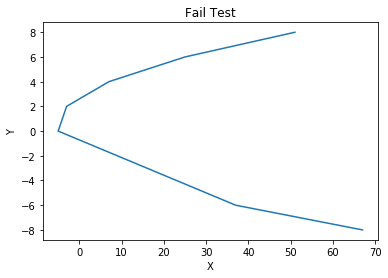

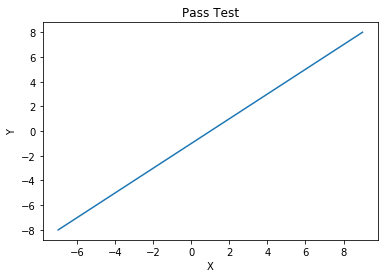

In [56]:
import matplotlib.pyplot as plt;

def getFailY(y):
  return (y**2)-(y)-5;

def getPassY(y):
  return y+1;

y = [-8, -6, -4 -2, 0, 2, 4, 6, 8]
xF = [getFailY(y[0]), getFailY(y[1]), getFailY(y[2]), getFailY(y[3]), getFailY(y[4]), getFailY(y[5]), getFailY(y[6]), getFailY(y[7])]
xP = [getPassY(y[0]), getPassY(y[1]), getPassY(y[2]), getPassY(y[3]), getPassY(y[4]), getPassY(y[5]), getPassY(y[6]), getPassY(y[7])]
plt.plot(xF, y);
plt.xlabel("X");
plt.ylabel("Y");
plt.title("Fail Test");
plt.show();

plt.plot(xP, y);
plt.xlabel("X");
plt.ylabel("Y");
plt.title("Pass Test");
plt.show();

## 1.2 Why are graphs that don't pass the vertical line test not considered "functions?"

# Functions as Relations

## 2.1 Which of the following relations are functions? Why?

\begin{align}
\text{Relation 1: } \{(1, 2), (3, 2), (1, 3)\}
\\
\text{Relation 2: } \{(1, 3), (2, 3), (6, 7)\}
\\
\text{Relation 3: } \{(9, 4), (2, 1), (9, 6)\}
\\
\text{Relation 4: } \{(6, 2), (8, 3), (6, 4)\}
\\
\text{Relation 5: } \{(2, 6), (2, 7), (2, 4)\}
\end{align}

Only Relation 2 is a function. It is the only relation where all the X values are different and only have one Y value each. In the other relations, one the X values is repeated at least once, which means that there is more than one Y value for that X value. Therefore only Relation 2 is a function.

# Functions as a mapping between dimensions


## 3.1 for the following functions what is the dimensionality of the domain (input) and codomain (range/output)?

\begin{align}
m(𝑥_1,𝑥_2,𝑥_3)=(x_1+x_2, x_1+x_3, x_2+x_3)
\\
n(𝑥_1,𝑥_2,𝑥_3,𝑥_4)=(x_2^2 + x_3, x_2x_4)
\end{align}

## 3.2 Do you think it's possible to create a function that maps from a lower dimensional space to a higher dimensional space? If so, provide an example.

# Vector Transformations

## 4.1 Plug the corresponding unit vectors into each function. Use the output vectors to create a transformation matrix.

\begin{align}
p(\begin{bmatrix}x_1 \\ x_2 \end{bmatrix}) = \begin{bmatrix} x_1 + 3x_2 \\2 x_2 - x_1 \\  \end{bmatrix}
\\
\\
q(\begin{bmatrix}x_1 \\ x_2 \\ x_3\end{bmatrix}) = \begin{bmatrix} 4x_1 + x_2 + 2x_3 \\2 x_2 - x_1 + 3x_3 \\ 5x_1 - 2x_3 + x_2  \end{bmatrix}
\end{align}

\begin{align}
\ x_1\begin{bmatrix} 1 \\-1  \end{bmatrix}+x_2\begin{bmatrix} 3 \\2  \end{bmatrix}
\end{align}
\
\begin{align}
\ x_1\begin{bmatrix} 4  \\ -1 \\ 5 \end{bmatrix} + x_2\begin{bmatrix} 1  \\ 2 \\ 1 \end{bmatrix} + x_3\begin{bmatrix} 2  \\ 3 \\ -2 \end{bmatrix}
\end{align}

\begin{align}
pT = \begin{bmatrix} 1 & 3 \\ -1 & 2 \end{bmatrix}
\end{align}
\
\begin{align}
qT = \begin{bmatrix} 4 & 1 & 2 \\ -1 & 2 & 3 \\ 5 & 1 & -2 \end{bmatrix}
\end{align}

## 4.2 Verify that your transformation matrices are correct by choosing an input matrix and calculating the result both via the traditional functions above and also via vector-matrix multiplication.

In [57]:
import numpy as np;
x1 = 1;
x2 = 2;
np.array([x1, x2])
print(x1*np.array([1, -1]) + x2*np.array([3, 2]))
np.matmul(np.matrix([[x1, 0], [0, x2]]), np.matrix([[1, 3], [-1, 2]]))


[7 3]


matrix([[ 1,  3],
        [-2,  4]])

# Eigenvalues and Eigenvectors

## 5.1 In your own words, give an explanation for the intuition behind eigenvalues and eigenvectors.

# The Curse of Dimensionality

## 6.1 What are some of the challenges of working with high dimensional spaces?

It becomes more difficult to explore data with high dimensional spaces. The larger the data, the more difficult it becomes to find what you need to find. If you can't find the data you're looking for, you can't work with it.

## 6.2 What is the rule of thumb for how many observations you should have compared to parameters in your model?

N = 5P. This shows a minimum of 5 observations, but having more is always better.

# Principal Component Analysis

## 7.1 Load the UCI Machine Learning Repository's [Iris Dataset](https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/d546eaee765268bf2f487608c537c05e22e4b221/iris.csv) and use PCA to isolate the dataset's first and second principal components and plot them on a graph. 

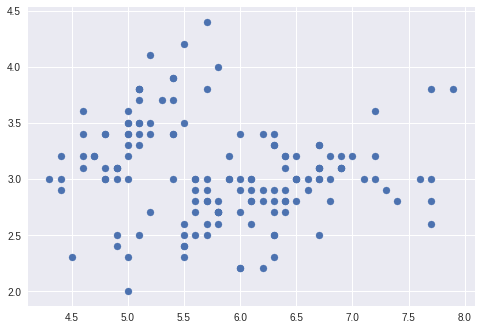

In [95]:
import pandas as pd;

df = pd.read_csv("https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/d546eaee765268bf2f487608c537c05e22e4b221/iris.csv");
df.head()
x = df.sepal_length;
y = df.sepal_width;
plt.style.use('seaborn')
plt.scatter(x, y)
plt.show()
data = np.array([x,y])
data = data.T;
means = np.mean(data.T, axis=1)
newData = (data-means)/(np.std(data.T, axis=1))
cov = np.cov(newData.T)

values, vectors = np.linalg.eig(cov)

P = vectors.T.dot(newData.T)
#xM = x-xmean;
#yM = y-ymean;
#print(np.std(x))
#xstd = xM/np.std(x)
#ystd = yM/np.std(y)
#print(xstd)
#np.cov(xstd)

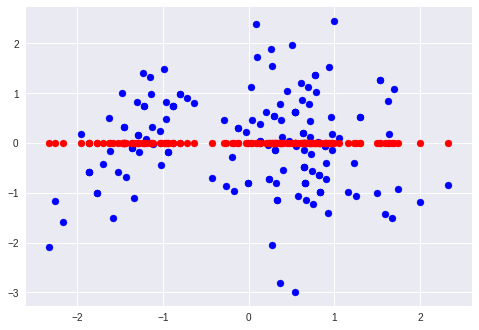

In [94]:
plt.style.use('seaborn')
plt.scatter(P.T[:, 1], P.T[:, 0], color='blue')
plt.scatter(P.T[:, 1], np.array([0]*len(P.T[:, 1])), color='red')

# Stretch Goal

## 1) Do NOT work on the stretch goal until you feel like you have a firm grasp of eigenvectors, eigenvalues, and PCA. Prioritize self-study over the stretch goal if you are not comfortable with those topics yet.

## 2) Explore further the intuition behind eigenvalues and eigenvectors by creating your very own eigenfaces:

![Eigenfaces](https://i.pinimg.com/236x/1c/f1/01/1cf101a9859437a5d096a04b05be06b4--faces-tattoo.jpg)

You don't necessarily have to use this resource, but this will get you started: 
[Eigenface Tutorial](https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/)